In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./plates"))

# Any results you write to the current directory are saved as output.

['test', 'train', '__MACOSX']


In [2]:
data_root = './plates/'
print(os.listdir('./val/dirty'))

['0000.jpg', '0006.jpg', '0012.jpg', '0018.jpg']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 79.90it/s]


In [4]:
dest_dir

'train\\dirty'

In [6]:
from PIL import Image
import numpy as np
from torchvision import transforms
from torchvision.transforms import ToTensor,ToPILImage
from matplotlib.pyplot import imshow

img_path="./val/dirty/0006.jpg"
image = Image.open(img_path, 'r')
imshow(np.asarray(image))
print(image.size)
# image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
# image = ToTensor()(image)
# print(image.size())
trans=transforms.Compose([
    transforms.ColorJitter(brightness=[1.0,2.0])])
image=trans(image)
# image=ToPILImage()(image)
print(image)
imshow(np.asarray(image)) 

(256, 341)
<PIL.Image.Image image mode=RGB size=256x341 at 0x16703934EF0>


In [8]:
import torch
import PIL
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


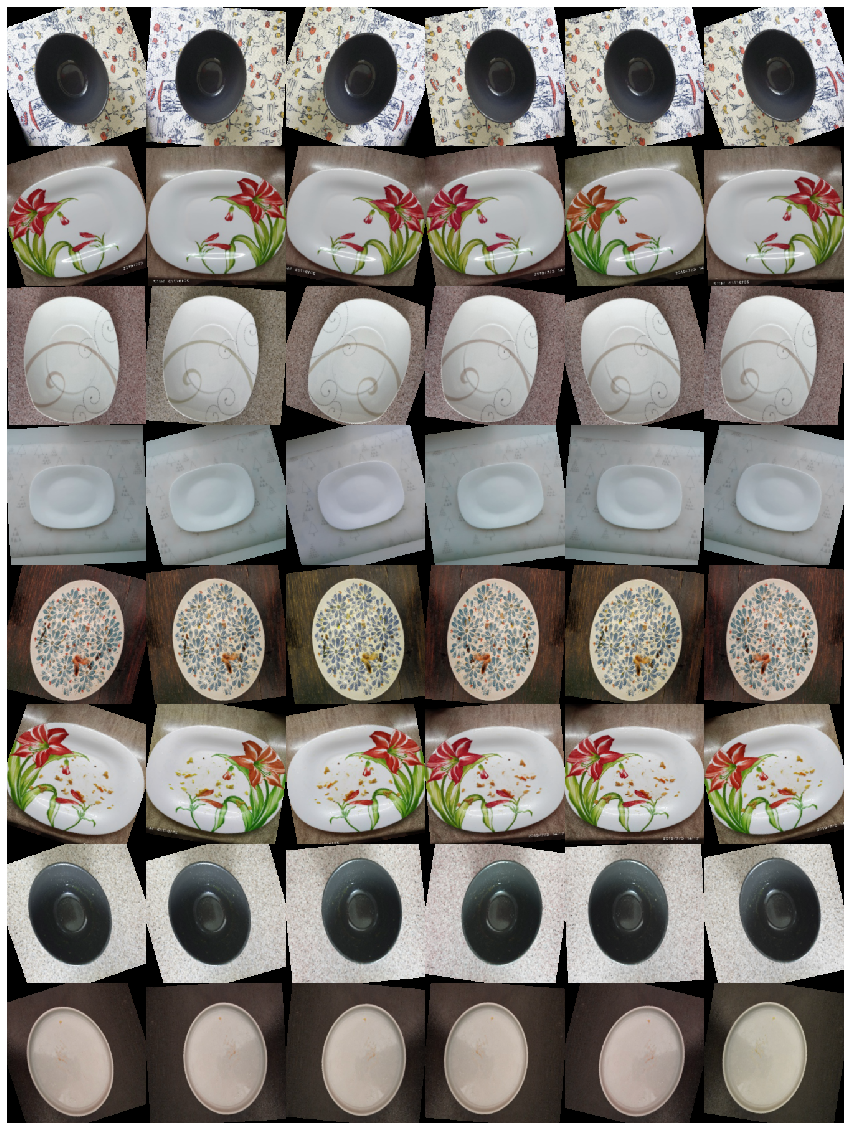

In [9]:
dataset1 = torchvision.datasets.ImageFolder('val',transform=transforms)
show_dataset(dataset1)

In [10]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('val', transform=transforms)


C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  import sys


C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


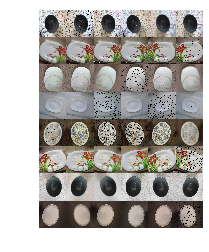

In [7]:
show_dataset(dataset)

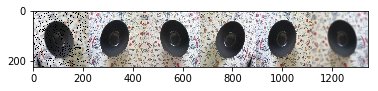

In [8]:
aug = iaa.Affine(rotate=(-40, 40), mode='symmetric')
imgs = [np.asarray(dataset[0][0]) for _ in range(6)]
aug.augment_images(imgs)
plt.imshow(np.hstack(imgs))

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  import sys
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


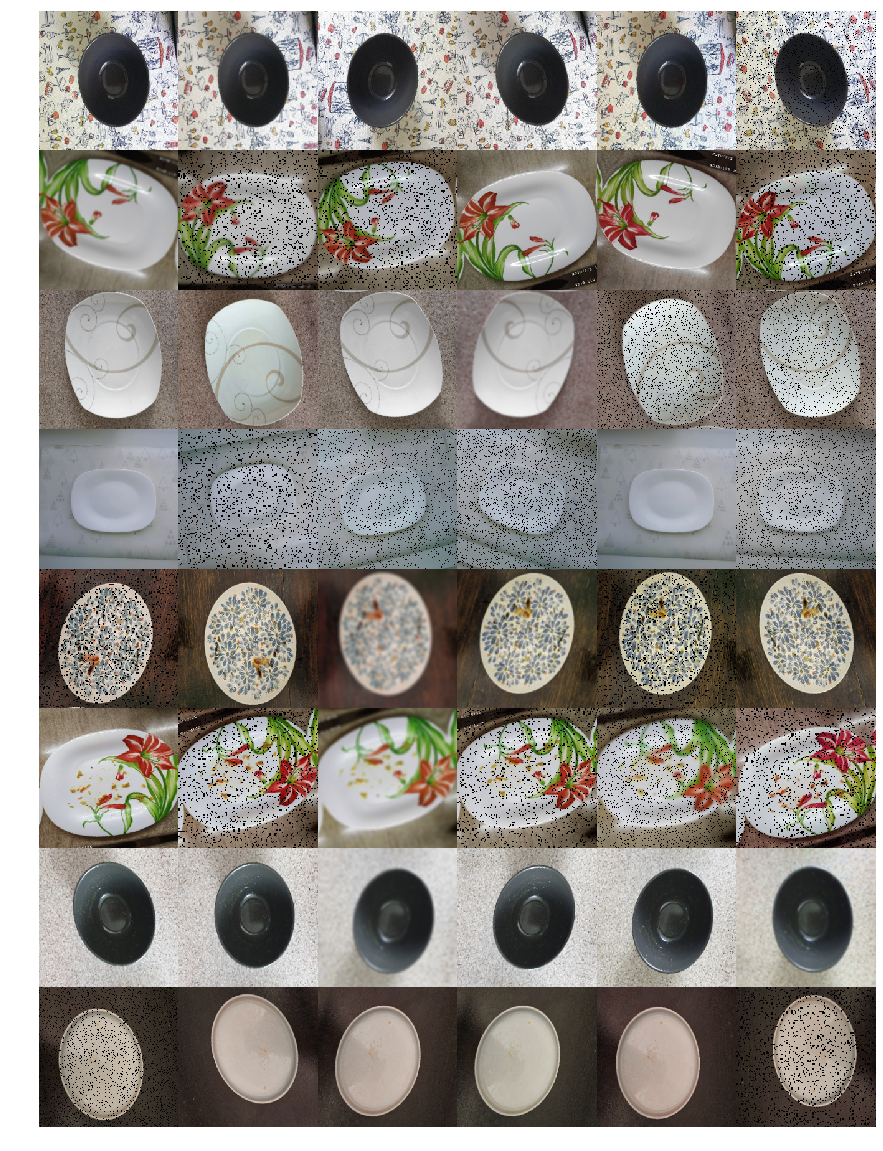

In [16]:
transforms = torchvision.transforms.Compose([
    ImgAugTransform(),lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip()
])

dataset = torchvision.datasets.ImageFolder('val', transform=transforms)

show_dataset(dataset)

In [11]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([ImgAugTransform(),lambda x: PIL.Image.fromarray(x),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  import sys


In [13]:
len(train_dataloader), len(train_dataset)

(4, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


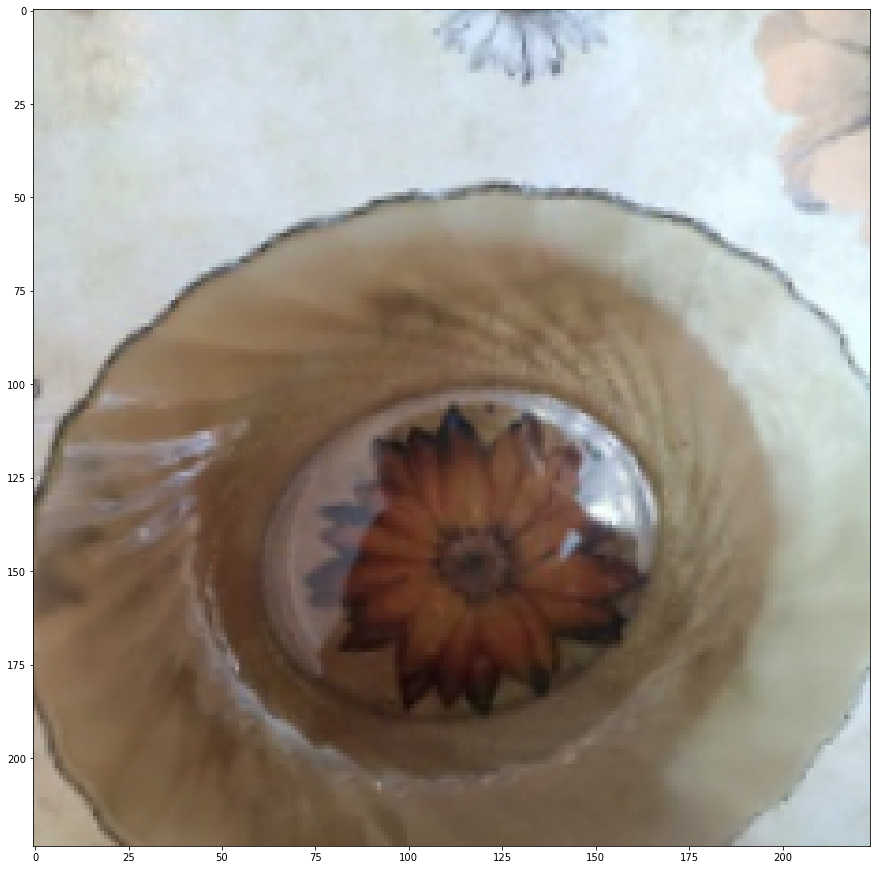

In [12]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

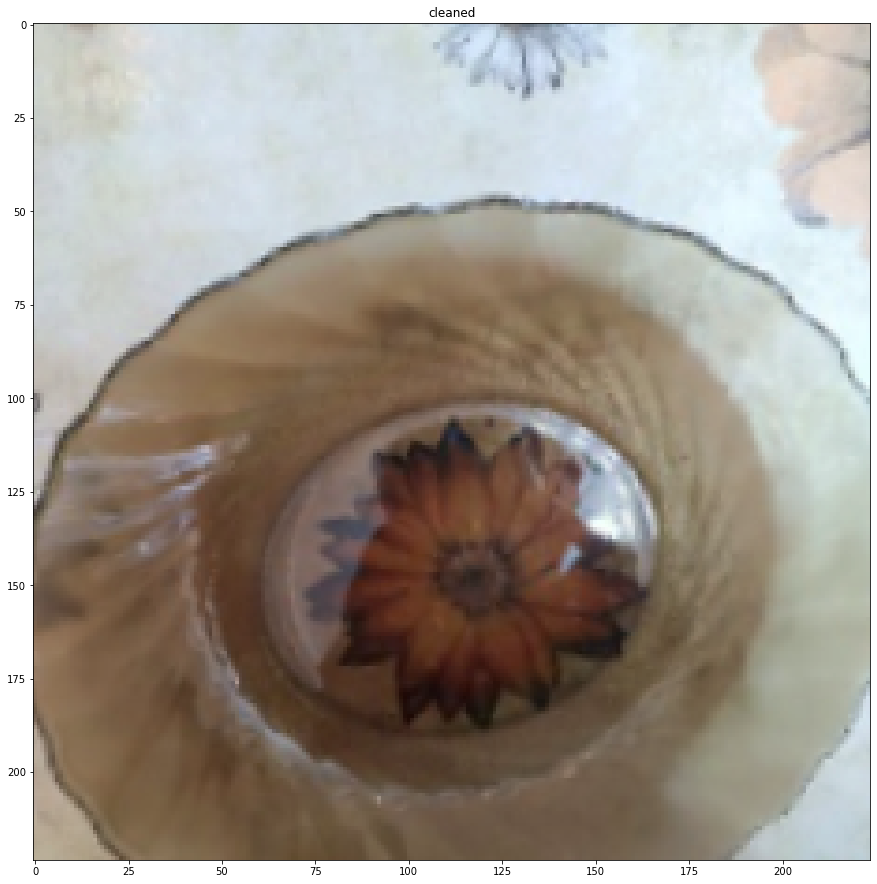

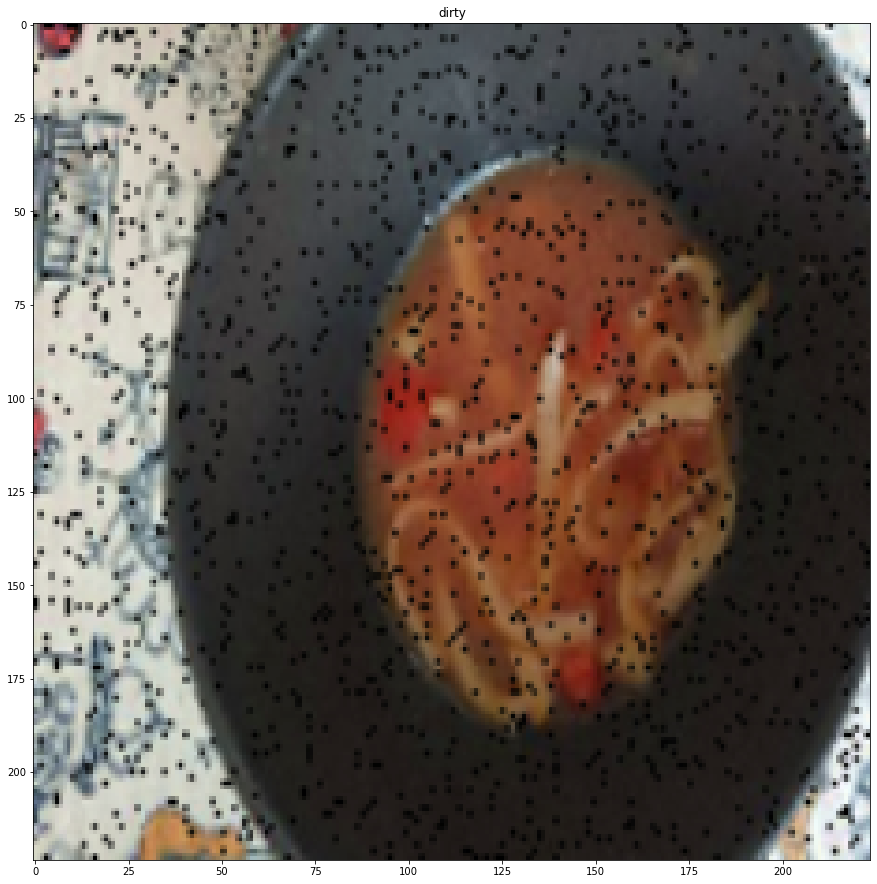

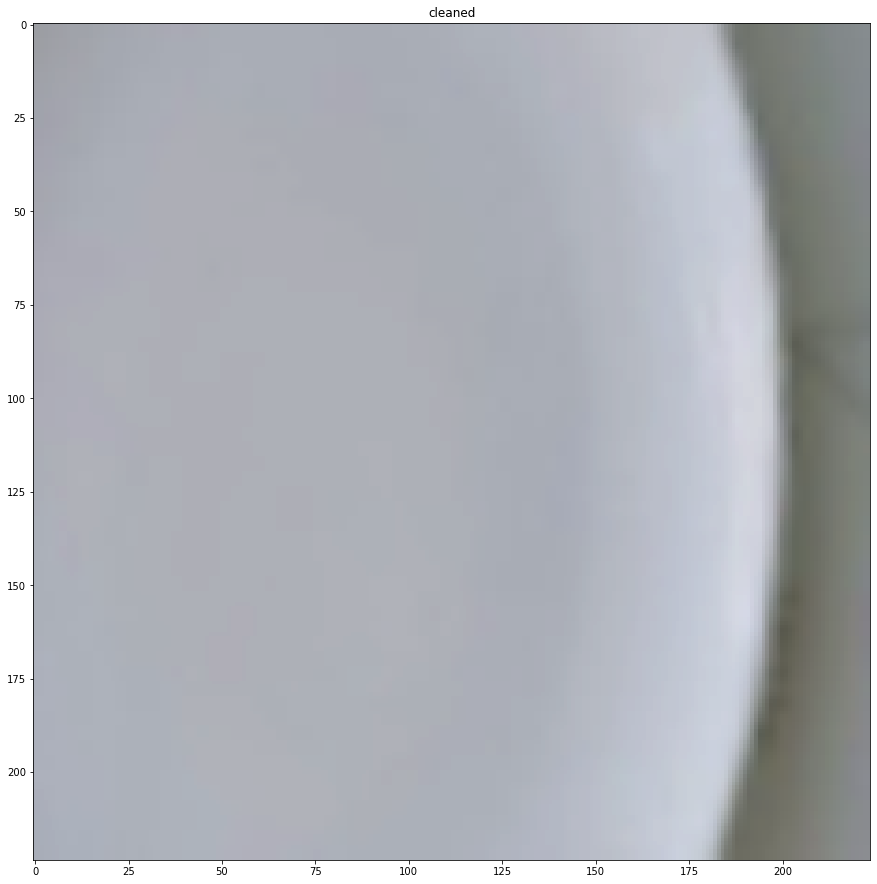

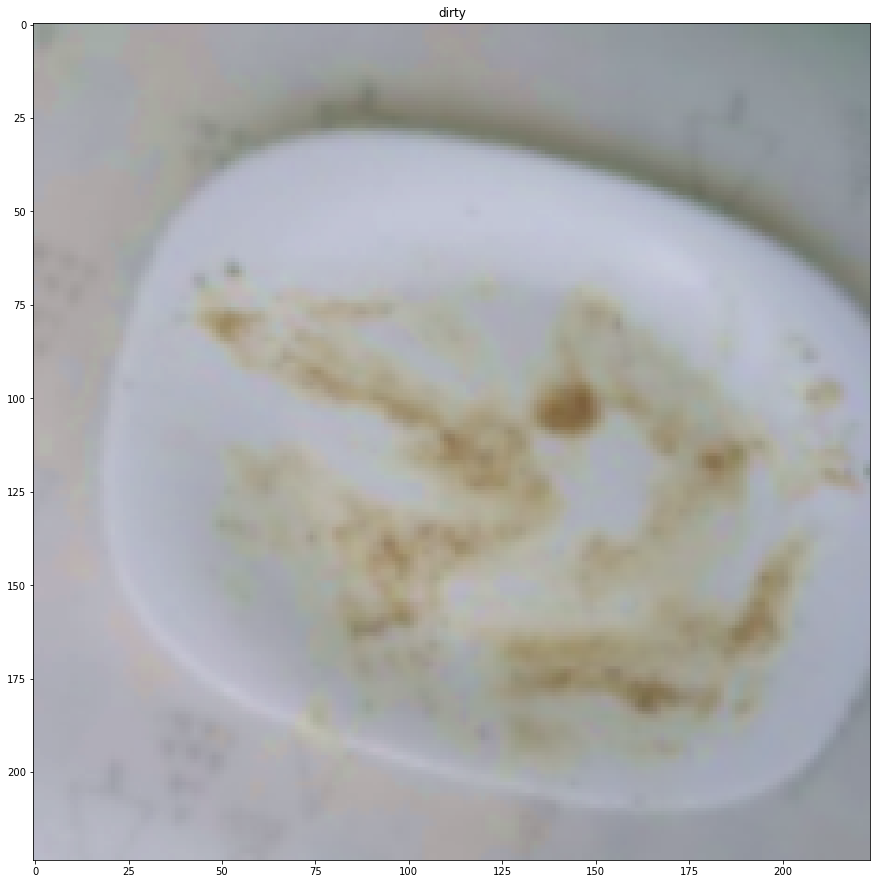

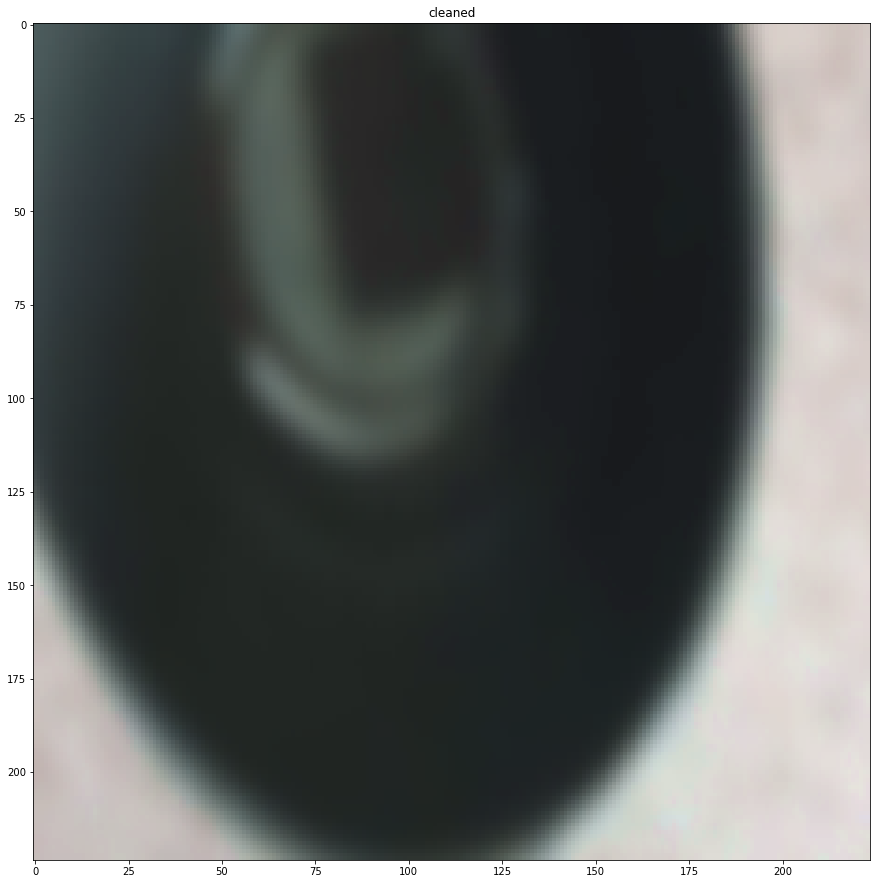

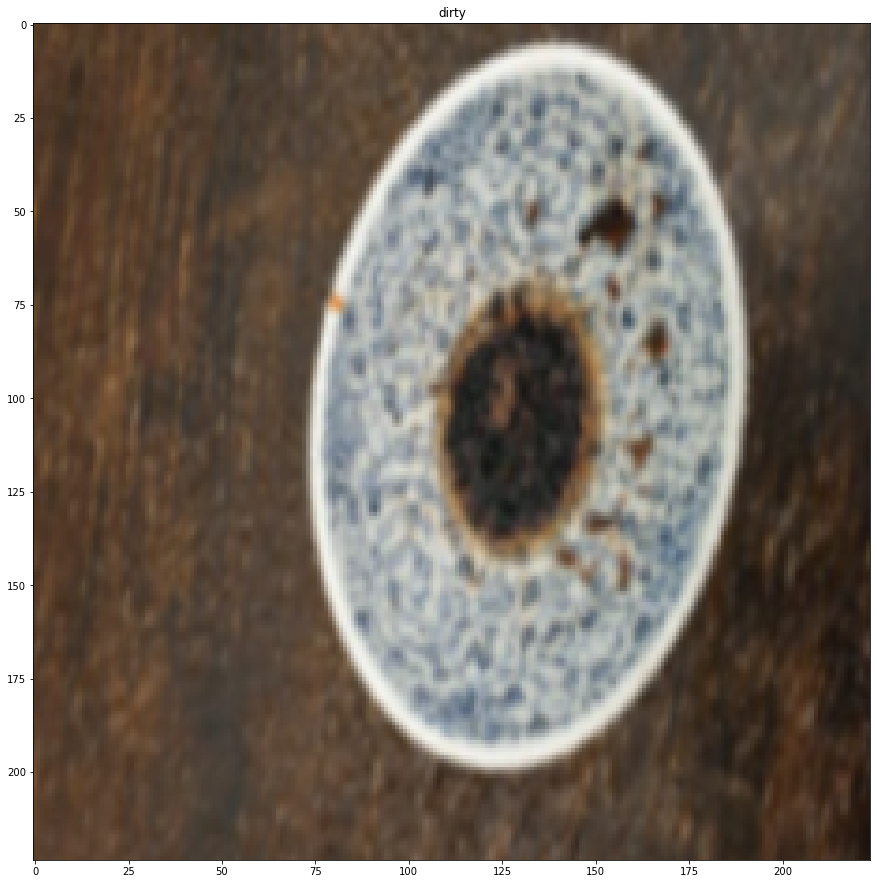

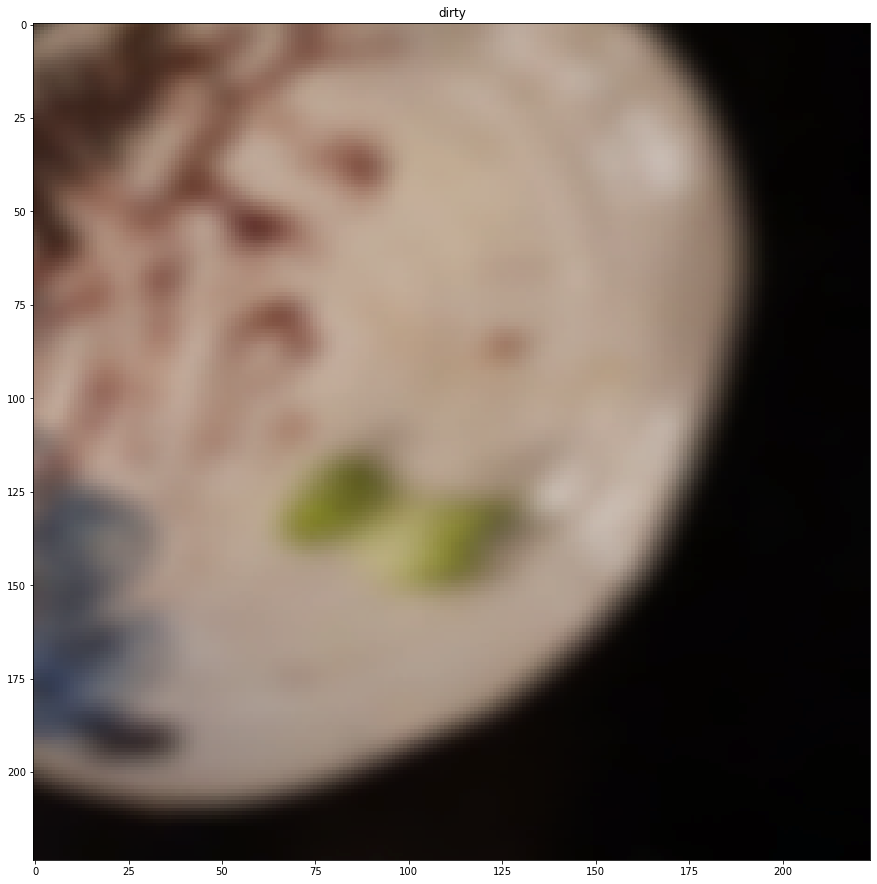

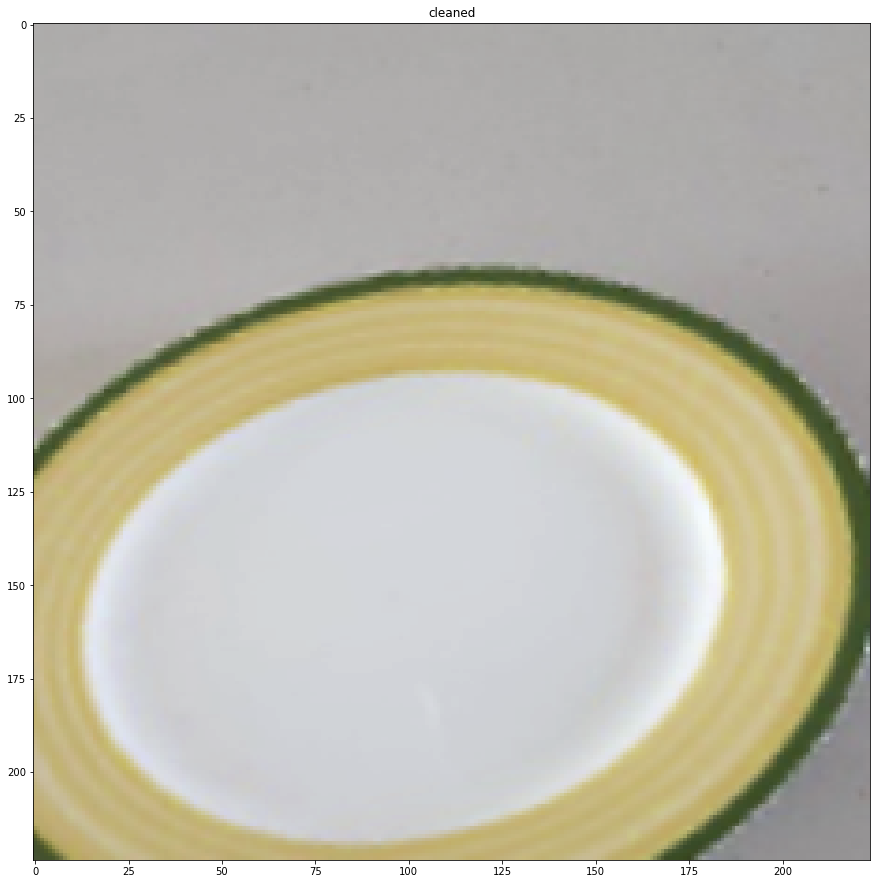

In [13]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
    X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [14]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [15]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

C:\Users\david\Anaconda3\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 580 which is of cuda capability 2.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [20]:
torch.backends.cudnn.enabled=False

In [21]:
xxx = torch.rand(13, 13).cuda()
yyy = torch.rand(13,13).cuda()
print(xxx+yyy)

RuntimeError: cuda runtime error (8) : invalid device function at c:\programdata\miniconda3\conda-bld\pytorch_1533094064887\work\aten\src\thc\generic/THCTensorMathPointwise.cu:266

In [18]:
torch.__version__

'0.4.1'

In [19]:
torch.backends.cudnn.version()

7005

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda0 = torch.device('cuda:0')
abc=torch.tensor([0.9200,0.08,1.0, 0.01])
x=torch.tensor(abc).to(cuda0)
# print(x)
print(x.device)
x=x.to('cpu')
print(x)
print(x.device)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


cuda:0
tensor([0.9200, 0.0800, 1.0000, 0.0100])
cpu


In [22]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


  0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (8) : invalid device function at c:\programdata\miniconda3\conda-bld\pytorch_1533094064887\work\aten\src\thc\generic/THCTensorMath.cu:15

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

submission_df.to_csv('submission.csv')

!rm -rf train val test

In [24]:
!nvidia-smi

"nvidia-smi" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
